# Deep Bucket Lab: 
## A playground for understanding hydrologic process representations with Deep Learning and Information Theory

This notebook is designed to help students understand the fundamentals of simulating dynamic systems with Deep Learning. 

The data is generated synthetically in this notebook based on simple numerical simulations of a hydrological system (leaking buckets) with varying characteristics/attributes and including dynamic forcings for precipitation. We will develop a single-layer Long Short-Term Memory (LSTM) network to learn dynamics of water level and fluxes out from the "ground truth" leaky bucket data. 

In this notebook, the user can experiment with modifying the system setup and exploring the outcomes to understand hydrologic process representations and their predictability.

(This cell can be removed after we finish)

- Updated by Jonathan April 26, 2023
    Edited variable names to match the preprint
    Edited the evaporation equation. But it is completely artificial, may want to make it more realistic.
- Updated by Jonathan April 26, 2023
    I am modifying the section titles, and order to match the flow of the preprint
    Adding back in the infiltration loss, which I took out for some reason at some point.

- Updated by Jonathan
    Add option to run with GPU
    little tweaks

- Update by Leila Hernandez R on April 18, 2023: 
    I check and ran all cells in the code, and it's working well. 
    I added a brief explanation in some cells. I added sections 7 and 8. Section 7 increase the number of training buckets, 
    store the results, and plot loss and RMSE. Section 8 uses Entropy and MI as metrics and needs more work.
    
- Updated by Maoya on 15 May, 2023: mostly editorial stuff to fix things I was a bit slow at understanding and cleaning up the markdown and code

# 1. Setup

The first thing to do is setup the notebook environment with all the libraries, declare model global parameters, settings and variables that define the bucket system we want to represent, and define the hyperparameters for the deep learning model. 

Note: in a typical full-scale modeling framework, these would be decalared in a configuration file.

### 1.1 Importing libraries 

We import standard libraries for data management, calculations and plotting. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

We import machine learning libraries for modeling architectures, training, validation and testing.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.autograd import Variable 
import sklearn
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import trange, tqdm

### 1.2 Defining the bucket system

**Global variables**

In [3]:
g = 9.807         # [m/s^2]
time_step = 1     # [s]

**Parameters for the forcing processes**

We will generate precipitation data with a simple random process that decides from the previous state if it is raining and the total amount of rain in the event. We define three types of possible precipitation (None, Light, Heavy) by a range of rainfall probability and a range of rainfall depth.

For example, light precipitation with a probability range [0.5, 0.8] means that ..?.. and a rain_depth_range [0, 2] means that the total amount of rainfall is determined by a random uniform distribution between 0 and 2.

In [4]:
rain_probability_range = {"None": [0.6, 0.7], "Light": [0.5, 0.8], "Heavy": [0.2, 0.3]}
rain_depth_range = {"Light": [0, 2], "Heavy": [2, 8]}

**Bucket attributes**

We will generate a diversity of leaky buckets by randomy selecting their attributes from a range of possibilities, including:
- bucket area (A_bucket)
- spigot areas (A_spigot)
- bucket heights (H_bucket)
- spigot heights (H_spigot)
- infiltration rate (K_infiltration)
- evapotranspiration parameter (ET_parameter) 

In [5]:
bucket_attributes_range = {"A_bucket": [1.0, 2.0],          # [m^2]
                           "A_spigot": [0.1, 0.2],          # [m^2]
                           "H_bucket": [5.0, 6.0],          # [m]
                           "H_spigot": [1.0, 3.0],          # [m]
                           "K_infiltration": [1e-7, 1e-9], # ... units?
                           "ET_parameter": [7, 9]          # ... units?
                          }
bucket_attributes_list = list(bucket_attributes_range.keys())

**Model variables**

The data fluxes in and out of the leaky bucket considered in this stystem and the leaky bucket state, include
- precipitation into the bucket
- the actual and potential loss to evaporation from the bucket (et, pet)
- the water flow over the bucket and out the spigot (q_overflow, q_spigot)
- and the state of the water head in the bucket (h_bucket)

We define lists based on the input and output leaky bucket model variables

In [6]:
input_vars = ['precipitation', 'et']
input_vars.extend(bucket_attributes_list)
output_vars = ['q_overflow', 'q_spigot']
n_input = len(input_vars)
n_output = len(output_vars)

**Data noise**

Because real world systems are noisy, we add a noise  by multipling the data values by a random factor taken from a normal distribution with a mean of 1 and a standard deviation prescribed for each component

In [7]:
is_noise = True
noise = {"pet": 0.1, "et": 0.1, "q": 0.1, "head": 0.1} 

**Data record and splits**

The deep learning framework requires the data to be split into 3 different sets
- Back propogation is done on the training (train) set
- Hyperparameter tuning is done on the validation (val) set
- Calculating model accuracy is done on the testing (test) set

We will define how many randomly generated bucket configurations to use for the train, val, and test sets as well as the length of the simulations for each set.

For example, for the training set 35 for the number of buckets split means that we will train the model on 35 randomly generated bucket configurations and 2500 for the time split means we will train the model on 2500 time step for each bucket.

In [8]:
n_buckets_split = {"train": 35, "val": 5,"test": 1}
time_splits = {"train": 2500, "val": 1500,"test": 200}

**Deep Learning Model (LSTM) Hyperparameters**

..todo? add more of an explanation for these ....?

In [9]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")#torch.cuda.device(0)
    print("Using CUDA device: ", torch.cuda.get_device_name(0))
else:
    device = 'cpu'
hidden_state_size = 16
num_layers = 8
num_epochs = 5  
batch_size = 256 
seq_length = 24
learning_rate = np.linspace(start=0.1, stop=0.01, num=num_epochs)

### 1.3 Calculating the system setup 

We use the settings above to calculate the total length of the data record to generate and the total number of buckets 

In [10]:
num_records = time_splits["train"] + time_splits["val"] + time_splits["test"] + seq_length * 3
n_buckets = n_buckets_split["train"] + n_buckets_split["val"] + n_buckets_split["test"]

We use the settings above to calculate the parameters for the bucket and time splits necessary to process the data sets for model training, validation and testing.

In [11]:
# Bucket splits
buckets_for_training = list(range(0, n_buckets_split['train'] + 1))
buckets_for_val = list(range(n_buckets_split['train'] + 1, n_buckets_split['train'] + n_buckets_split['val'] + 1))
buckets_for_test = list(range(n_buckets - n_buckets_split['test'], n_buckets))

# Time splits
train_start = seq_length
train_end   = time_splits["train"]
val_start   = train_end + seq_length
val_end     = val_start + time_splits["val"]
test_start  = val_end + seq_length
test_end    = test_start + time_splits["test"]

We use the settings above to define the bucket boundary and initial conditions by randomly sampling from the possible ranges for each sttribute

In [12]:
def setup_buckets():
    # Boundary conditions
    buckets = {bucket_attribute:[] for bucket_attribute in bucket_attributes_list}
    for i in range(n_buckets):
        for attribute in bucket_attributes_list:
            buckets[attribute].append(np.random.uniform(bucket_attributes_range[attribute][0], 
                                                        bucket_attributes_range[attribute][1]))

    # Initial conditions
    h_water_level = [np.random.random() for i in range(n_buckets)]
    mass_overflow = [np.random.random() for i in range(n_buckets)]
    return buckets, h_water_level, mass_overflow

In [13]:
buckets, h_water_level, mass_overflow = setup_buckets()

### 1.4 Creating the synthetic "precipitation" 

We use the parameters for precipitation as a random process defined above to generate a synthetic input time series for the bucket model (forcing data).

In [14]:
def generate_random_rain(preceding_rain, buck_rain_params):
        depth_range, no_rain_probability, light_rain_probability, heavy_rain_probability = buck_rain_params
        # some percent of time we have no rain at all
        if np.random.uniform(0.01,0.99) < no_rain_probability:
            rain = 0

        # When we do have rain, the probability of heavy or light rain depends on the previous day's rainfall
        else:
            # If yesterday was a light rainy day, or no rain, then we are likely to have light rain today
            if preceding_rain < depth_range["Light"][1]:
                if np.random.uniform(0,1) < light_rain_probability:
                    rain = np.random.uniform(0, 1)
                else:
                    # But if we do have heavy rain, then it could be very heavy
                    rain = np.random.uniform(depth_range["Heavy"][0], depth_range["Heavy"][1])

            # If it was heavy rain yesterday, then we might have heavy rain again today
            else:
                if np.random.uniform(0, 1) < heavy_rain_probability:
                    rain = np.random.uniform(0, 1)
                else:
                    rain = np.random.uniform(depth_range["Light"][0], depth_range["Light"][1])
        return rain

In [15]:
def generate_forcing_timeseries():
    in_list = {i:[0] for i in range(n_buckets)}

    for bucket in range(n_buckets):
        buck_rain_params = [rain_depth_range,
                            np.random.uniform(rain_probability_range["None"][0],
                                                rain_probability_range["None"][1]),
                            np.random.uniform(rain_probability_range["Heavy"][0],
                                                rain_probability_range["Heavy"][1]),
                            np.random.uniform(rain_probability_range["Light"][0],
                                                rain_probability_range["Light"][1])
                     ]

        in_list[bucket] = [0]
        for i in range(1, num_records):
            in_list[bucket].append(generate_random_rain(in_list[bucket][i-1], buck_rain_params))
                                   
    return in_list

We generate a random rainfall input timeseries for each bucket and store it in a list

In [16]:
in_list = generate_forcing_timeseries()

### 1.5 Runing the bucket model numerical simulations to generate "ground truth" data
We run the bucket model simulation to generate the data for our known system. These data represent the "ground truth", which is what we will try to learn with the LSTM. 

Note: We choose to represent a leaking bucket because this stystem is much simpler than, say, a watershed. So we can be a little more confident that our synthetic leaking buckets approximantes the real-world process.

In [17]:
def run_bucket_simulation(ibuc):
    columns = ['precipitaion', 'et', 'h_bucket', 'q_overflow', 'q_spigot']
    columns.extend(bucket_attributes_list)
    # Memory to store model results
    df = pd.DataFrame(index=list(range(len(in_list[ibuc]))), columns=columns)
    
    # Main loop through time
    for t, precip_in in enumerate(in_list[ibuc]):
        
        # Add the input mass to the bucket
        h_water_level[ibuc] = h_water_level[ibuc] + precip_in

        # Lose mass out of the bucket. Some periodic type loss, evaporation, and some infiltration...
        et = np.max([0, (buckets["A_bucket"][ibuc] / buckets["ET_parameter"][ibuc]) * np.sin(t) * np.random.normal(1, noise['pet'])])
        infiltration = h_water_level[ibuc] * buckets["K_infiltration"][ibuc]
        h_water_level[ibuc] = np.max([0 , (h_water_level[ibuc] - et)])
        h_water_level[ibuc] = np.max([0 , (h_water_level[ibuc] - infiltration)])
        if is_noise:
            h_water_level[ibuc] = h_water_level[ibuc] * np.random.normal(1, noise['et'])

        # Overflow if the bucket is too full
        if h_water_level[ibuc] > buckets["H_bucket"][ibuc]:
            mass_overflow[ibuc] = h_water_level[ibuc] - buckets["H_bucket"][ibuc]
            h_water_level[ibuc] = buckets["H_bucket"][ibuc] 
            if is_noise:
                h_water_level[ibuc] = h_water_level[ibuc] - np.random.uniform(0, noise['q'])

        # Calculate head on the spigot
        h_head_over_spigot = (h_water_level[ibuc] - buckets["H_spigot"][ibuc] ) 
        if is_noise:
            h_head_over_spigot = h_head_over_spigot * np.random.normal(1, noise['head'])

        # Calculate water leaving bucket through spigot
        if h_head_over_spigot > 0:
            velocity_out = np.sqrt(2 * g * h_head_over_spigot)
            spigot_out = velocity_out *  buckets["A_spigot"][ibuc] * time_step
            h_water_level[ibuc] = h_water_level[ibuc] - spigot_out
        else:
            spigot_out = 0

        # Save the data in time series
        df.loc[t,'precipitation'] = precip_in
        df.loc[t,'et'] = et
        df.loc[t,'h_bucket'] = h_water_level[ibuc]
        df.loc[t,'q_overflow'] = mass_overflow[ibuc]
        df.loc[t,'q_spigot'] = spigot_out
        for attribute in bucket_attributes_list:
            df.loc[t, attribute] = buckets[attribute][ibuc]

        mass_overflow[ibuc] = 0
        
    return df

We store the simulations for each bucket in a dictionnary

In [18]:
bucket_dictionary = {}
for ibuc in range(n_buckets):
    bucket_dictionary[ibuc] = run_bucket_simulation(ibuc)

### 1.6 Visualizing a sample of the bucket fluxes
We plot the model simulations to verify that the generated values are realistic and that they have fluxes from both the spigot (channel flow) and over the top (flooding) exisit.

In [19]:
def viz_simulation(ibuc):
    fig = plt.figure(figsize=(12, 3))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    print('Bucket:', ibuc)
    print("Overflow mean:", np.round(bucket_dictionary[ibuc].q_overflow.mean(),2))
    print("Overflow max:", np.round(bucket_dictionary[ibuc].q_overflow.max(),2))
    bucket_dictionary[ibuc].loc[:100,input_vars].plot(ax=ax1)
    bucket_dictionary[ibuc].loc[:100,output_vars].plot(ax=ax2)
    bucket_dictionary[ibuc].loc[:100,"h_bucket"].plot(ax=ax2)
    ax1.set_title('Model inputs')
    ax2.set_title('Model outputs')
    plt.legend()
    plt.show()
    plt.close()

Bucket: 36
Overflow mean: 0.49
Overflow max: 7.83


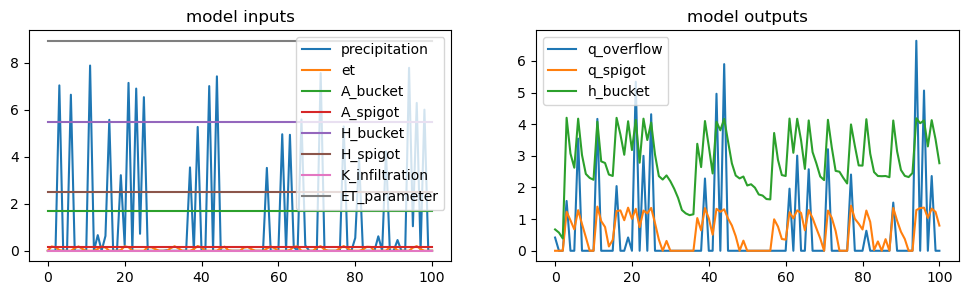

Bucket: 37
Overflow mean: 0.51
Overflow max: 8.45


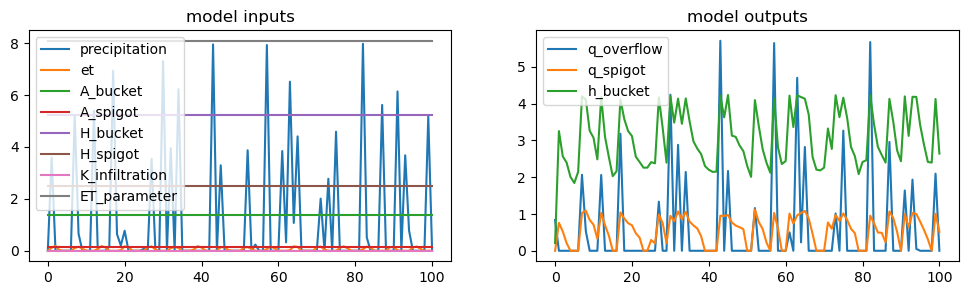

Bucket: 38
Overflow mean: 0.36
Overflow max: 8.34


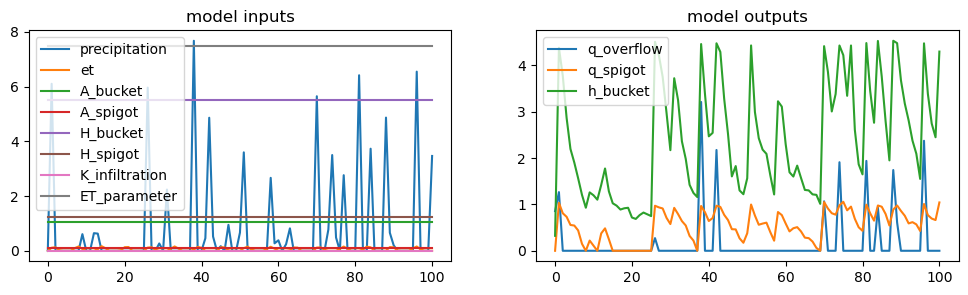

Bucket: 39
Overflow mean: 0.49
Overflow max: 8.41


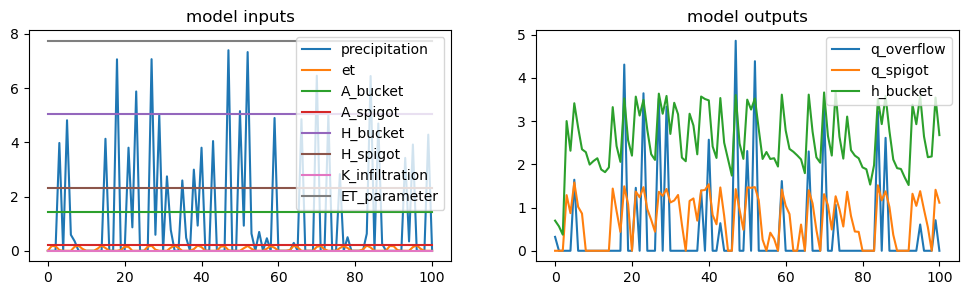

Bucket: 40
Overflow mean: 0.45
Overflow max: 8.16


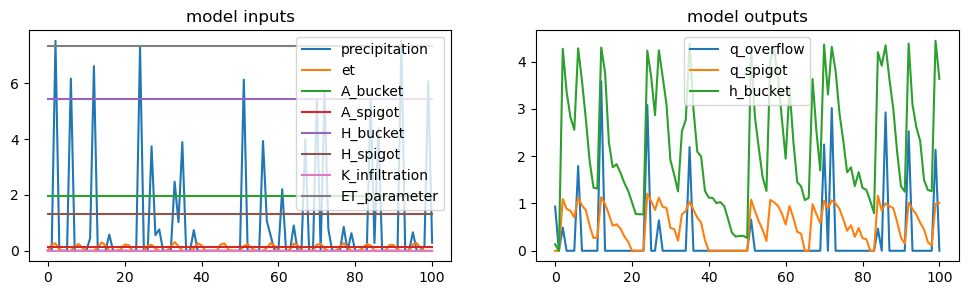

In [20]:
for ibuc in buckets_for_val:
    viz_simulation(ibuc)

# 2. Deep learning model
This section sets up our deep learning model and training procedure.

### 2.1 Defining the neural network model
This is the part of the notebook that we will actually use the defined simulations to learn from the generated data and then make predictions. 

We define a class called LSTM1, which is a PyTorch module for a single-layer Long Short-Term Memory (LSTM) network. 

**Brief explanation**


- The input to the module is a tensor x of shape (batch_size, seq_length, input_size), which represents a sequence of batch_size samples, each of length seq_length, with input_size features at each time step. 
- The LSTM layer is defined using the nn.LSTM class, with input_size as the size of the input layer, hidden_size as the size of the hidden state, and batch_first=True indicating that the first dimension of the input tensor is the batch size. 
- The output of the LSTM layer is passed through a ReLU activation function, and then to a fully connected layer (nn.Linear) with num_classes output units. 
- The forward method takes the input tensor x as an argument, along with an optional tuple init_states representing the initial hidden and internal states of the LSTM layer, and returns the output tensor prediction. 
- If init_states is not provided, it is initialized as a tensor of zeros with shape (batch_size, hidden_size).

In [21]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, batch_size, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length 
        self.batch_size = batch_size

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.fc_1 =  nn.Linear(hidden_size, num_classes) #fully connected 1
   
    def forward(self, x, init_states=None):

        if init_states is None:
            h_t = Variable(torch.zeros(batch_size, self.hidden_size)) # hidden state
            c_t = Variable(torch.zeros(batch_size, self.hidden_size)) # internal state
        else:
            h_t, c_t = init_states
           
        out, _ = self.lstm(x)
        out = self.relu(out)
        prediction = self.fc_1(out) # Dense, fully connected layer
        
        return prediction

### 2.2 Defining a procedure for model validation
Here we verify that our model is working the way we expect. We would especially want to check model validation when changing hyperparameters.

We define a function that validates and tests the LSTM model, as well as checks the water balance of the system. 

**Brief explanation**
- We use a pre-defined the LSTM model to make predictions on the validation data. 
- The output of this model is then used to compute two different metrics, the Nash-Sutcliffe Efficiency (NSE) for the spigot_out and mass_overflow columns of the dataframe.
- We plot the actual spigot_out and mass_overflow values against their corresponding LSTM predictions. 
- We check the water balance of the system by summing up the input, evapotranspiration, mass_overflow, spigot_out, and the last recorded water level in the dataframe, and compare this to the total mass out of or left in the system. 
- We print out the percent mass residual as a measure of how well the system is balanced.

In [22]:
def check_validation_period(lstm, np_val_seq_X, ibuc, n_plot=100):
    
    def __make_prediction():
        lstm_output_val = lstm(torch.Tensor(np_val_seq_X[ibuc]).to(device=device))
        val_spigot_prediction = []
        val_overflow_prediction = []
        for i in range(lstm_output_val.shape[0]):
            val_spigot_prediction.append((lstm_output_val[i,-1,1].cpu().detach().numpy() * \
                                    np.std(df.loc[train_start:train_end,'q_spigot'])) + \
                                   np.mean(df.loc[train_start:train_end,'q_spigot']))

            val_overflow_prediction.append((lstm_output_val[i,-1,0].cpu().detach().numpy() * \
                                    np.std(df.loc[train_start:train_end,'q_overflow'])) + \
                                   np.mean(df.loc[train_start:train_end,'q_overflow']))
        return val_spigot_prediction, val_overflow_prediction
    
    def __compute_nse():
        spigot_out = df.loc[val_start:val_end, 'q_spigot']
        spigot_mean = np.mean(spigot_out)
        spigot_pred_variance = 0
        spigot_obs_variance = 0

        overflow_out = df.loc[val_start:val_end, 'q_overflow']
        overflow_mean = np.mean(overflow_out)
        overflow_pred_variance = 0
        overflow_obs_variance = 0

        for i, pred_spigot in enumerate(val_spigot_prediction):
            t = i + seq_length - 1
            spigot_pred_variance += np.power(( pred_spigot          - spigot_out.values[t]), 2)
            spigot_obs_variance  += np.power(( spigot_mean          - spigot_out.values[t]), 2)

        for i, pred_overflow in enumerate(val_overflow_prediction):
            t = i + seq_length - 1
            overflow_pred_variance += np.power((pred_overflow          - overflow_out.values[t]), 2)
            overflow_obs_variance  += np.power((overflow_mean          - overflow_out.values[t]), 2)
        spigot_nse = np.round( 1 - ( spigot_pred_variance / spigot_obs_variance   ), 4)
        overland_flow_nse = np.round( 1 - ( overflow_pred_variance / overflow_obs_variance ), 4)
        return spigot_nse, overland_flow_nse

    def __compute_mass_balance():
        mass_in = df.sum()['precipitation']
        mass_out = df.sum()['et'] + \
                   df.sum()['q_overflow'] + \
                   df.sum()['q_spigot'] + \
                   df.loc[num_records - 1, 'h_bucket']
        return mass_in, mass_out

        
    df = bucket_dictionary[ibuc]
    val_spigot_prediction, val_overflow_prediction = __make_prediction()
    spigot_nse, overland_flow_nse = __compute_nse()
    mass_in, mass_out = __compute_mass_balance()
        
    print("Spigot NSE", spigot_nse)
    print("Overflow NSE", overland_flow_nse)
    print("Mass into the system: ", mass_in)
    print("Mass out or left over:", mass_out)
    print("percent mass resudual: {:.0%}".format((mass_in - mass_out) /mass_in))
        
    plt.plot(df.loc[val_start + seq_length-1:val_start+n_plot+seq_length - 1,'q_spigot'].values, label="Spigot out")
    plt.plot(val_spigot_prediction[:n_plot], label="LSTM spigot out")
    plt.legend()
    plt.show()
    plt.close()
    plt.plot(df.loc[val_start+seq_length-1:val_start+n_plot+seq_length-1,'q_overflow'].values, label="Overflow")
    plt.plot(val_overflow_prediction[:n_plot], label="LSTM Overflow")
    plt.legend()
    plt.show()
    plt.close()

### 2.3 Instantiating the neural network model (LSTM)

Using the hyperparameters from Section 1.2, we define a specific instance of the LSTM model and set up the LSTM

In [23]:
torch.manual_seed(1)
lstm = LSTM1(num_classes=n_output,  
             input_size=n_input,    
             hidden_size=hidden_state_size, 
             num_layers=num_layers, 
             batch_size=batch_size, 
             seq_length=seq_length).to(device=device)

### 2.4 Setting up the data to feed into the model

We will set up data for:
- training, to calculate the loss which is backpropogated through the model
- validation, where we get predictions from the trained model and see if the performance is up to our standards
- testing, the data we will utilately use to report the LSTM performance. 

Note: testing is the last thing we would do, if we go back to validation after this step, we would be P-hacking.

**Fitting a scaler to the training set to transform all the data**

...? maybe add some explanation here....

In [24]:
def fit_scaler():
    frames = [bucket_dictionary[ibuc].loc[train_start:train_end,input_vars] for ibuc in buckets_for_training]
    df_in = pd.concat(frames)    
    scaler_in = StandardScaler()
    scaler_train_in = scaler_in.fit_transform(df_in)

    frames = [bucket_dictionary[ibuc].loc[train_start:train_end,output_vars] for ibuc in buckets_for_training]
    df_out = pd.concat(frames)    
    scaler_out = StandardScaler()
    scaler_train_out = scaler_out.fit_transform(df_out)
    return scaler_in, scaler_out

In [25]:
scaler_in, scaler_out = fit_scaler()

**Function to create data loader for each data split**

... check that this works the same ??... you may have had a typo in the previous version because you had  'scaller_test_in, scaler_test_out' in the section for the training loader...maybe that was why everything was slow because all the data was fed for each bucket vs data for each individual bucket ?

In [26]:
def make_data_loader(start, end, bucket_list):
    loader = {}
    np_seq_X = {}
    np_seq_y = {}
    for ibuc in bucket_list:
        df = bucket_dictionary[ibuc]
        scaler_in_i = scaler_in.transform(df.loc[start:end, input_vars])
        scaler_out_i = scaler_out.transform(df.loc[start:end, output_vars])
        np_seq_X[ibuc] = np.zeros((scaler_in_i.shape[0] - seq_length, seq_length, n_input))
        np_seq_y[ibuc] = np.zeros((scaler_out_i.shape[0] - seq_length, seq_length, n_output))
        for i in range(0, scaler_in_i.shape[0] - seq_length):
            t = i+seq_length
            np_seq_X[ibuc][i, :, :] = scaler_in_i[i:t,:]
            np_seq_y[ibuc][i, :, :] = scaler_out_i[i:t,:]

        ds = torch.utils.data.TensorDataset(torch.Tensor(np_seq_X[ibuc]), 
                                                  torch.Tensor(np_seq_y[ibuc]))
        loader[ibuc] = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)
    return loader, np_seq_X, np_seq_y

Training, validation, test data loaders

In [27]:
train_loader, np_train_seq_X, np_train_seq_y = make_data_loader(train_start, train_end, buckets_for_training)
val_loader, np_val_seq_X, np_val_seq_y = make_data_loader(val_start, val_end, buckets_for_val)
test_loader, np_test_seq_X, np_test_seq_y = make_data_loader(test_start, test_end, buckets_for_test)

### 2.5 Training the model: Learning the general response of the example dynamic ''hydrologic" system
Now is the time to train the model. Everything above was done in preparation for this step.

Here we define a function to train the LSTM neural network model with the nn.MSELoss() loss function and using the Adam optimizer and hyperparameters defined above

**Brief explanation**:
- The training is done for a specified number of epochs
- For each epoch, the training data is divided into buckets. 
- For each bucket, the data is loaded using a PyTorch DataLoader and passed through the LSTM model. 
- The output is then compared with the target values using the custom loss function. 
- The gradients are calculated and the optimizer is used to update the weights of the model. 
- We use the tqdm library to show the progress of the training. 
- Finally, we estimate the average RMSE for each epoch. 

In [28]:
def train_model(lstm, train_loader, buckets_for_training):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(lstm.parameters(), lr=learning_rate[0])
    epoch_bar = tqdm(range(num_epochs),desc="Training", position=0, total=num_epochs)
    
    # Create a dictionary to store the results
    results = {}
    for epoch in epoch_bar:

        for ibuc in buckets_for_training:

            batch_bar = tqdm(enumerate(train_loader[ibuc]),
                             desc="Bucket: {}, Epoch: {}".format(str(ibuc),str(epoch)),
                             position=1,
                             total=len(train_loader[ibuc]), leave=False, disable=True)

            for i, (data, targets) in batch_bar:

                optimizer.zero_grad()

                optimizer = optim.Adam(lstm.parameters(), lr=learning_rate[epoch])

                data = data.to(device=device)
                targets = targets.to(device=device)

                # Forward
                lstm_output = lstm(data) 
                loss = criterion(lstm_output, targets)

                #backward
                optimizer.zero_grad()
                loss.backward()

                # gradient descent or adam step
                optimizer.step()

                batch_bar.set_postfix(loss=loss.to(device).item(),
                                      RMSE="{:.2f}".format(loss**(1/2)),
                                      epoch=epoch)
                batch_bar.update()

            with torch.no_grad():
                rmse_list = []
                for i, (data_, targets_) in enumerate(train_loader[ibuc]):
                    data_ = data_.to(device=device)
                    targets_ = targets_.to(device=device)
                    lstm_output_ = lstm(data_)
                    MSE_ = criterion(lstm_output_, targets_)
                    rmse_list.append(MSE_**(1/2))

            meanrmse = np.mean(np.array(torch.Tensor(rmse_list)))
            epoch_bar.set_postfix(loss=loss.cpu().item(),
                                  RMSE="{:.2f}".format(meanrmse),
                                  epoch=epoch)
            
            if ibuc not in results:
                results[ibuc] = {"loss": [], "RMSE": []}
            results[ibuc]["loss"].append(loss.cpu().item())
            results[ibuc]["RMSE"].append(meanrmse)
            #....todo?? also add IT metrics in results in this function ...
            batch_bar.update()

        𝗰𝗹𝗲𝗮𝗿_𝗼𝘂𝘁𝗽𝘂𝘁
        
    return lstm, results

**Run the train model functon by prescribing the buckets and data to use for training and the intantiated LSTM**

In [29]:
lstm, results = train_model(lstm, train_loader, buckets_for_training)

Training:   0%|          | 0/5 [00:00<?, ?it/s]

### 2.5 Visualizing the learning curves

 We plot the loss and rmse metrics for each epoch to check if the model fitting has converged

In [30]:
def viz_learning_curve(results):
    fig = plt.figure(figsize=(12, 3))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    for ibuc in buckets_for_training:
        ax1.plot(range(num_epochs), results[ibuc]['loss'])
        ax2.plot(range(num_epochs), results[ibuc]['RMSE'])
    ax1.set_ylabel('Loss')
    ax2.set_ylabel('RMSE')
    ax1.set_xlabel('Epoch')
    ax2.set_xlabel('Epoch')
    plt.suptitle("Learning curves for each bucket") 
    plt.show()

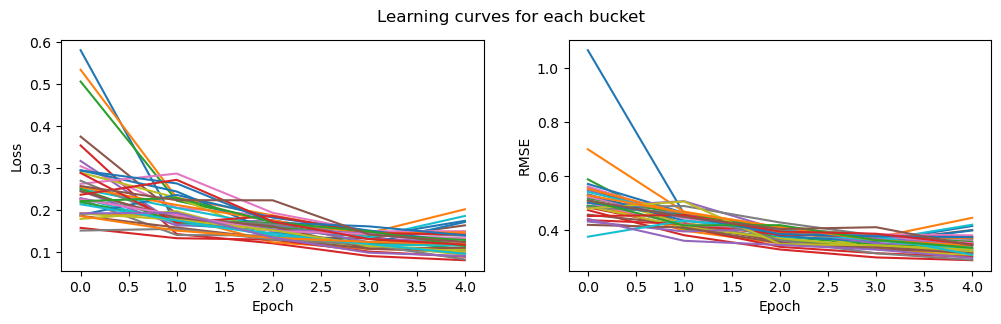

In [31]:
viz_learning_curve(results)

### 2.6 Checking that the model works on the validation data
Now that we have a trained model, we can see how it works on our validation split.

Spigot NSE 0.8396
Overflow NSE 0.87
Mass into the system:  5255.087072735561
Mass out or left over: 5182.7483376728405
percent mass resudual: 1%


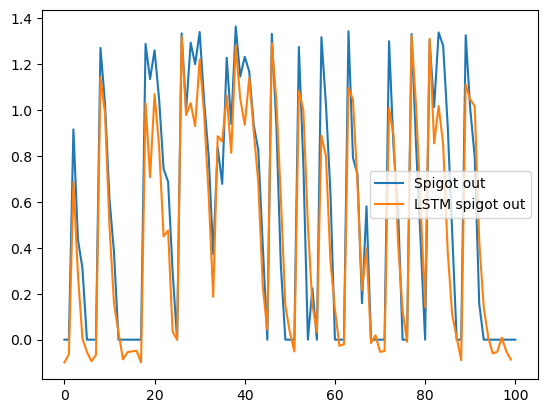

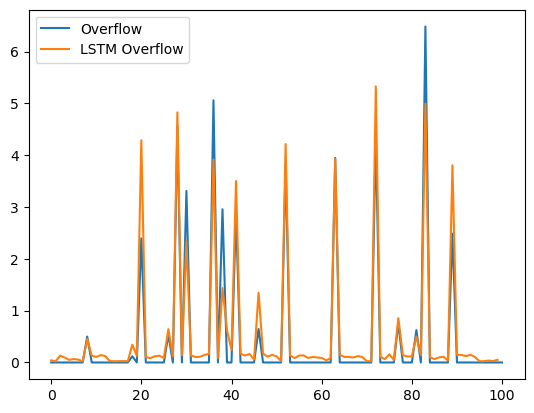

Spigot NSE 0.6545
Overflow NSE 0.8634
Mass into the system:  4765.593289024384
Mass out or left over: 4721.274700581239
percent mass resudual: 1%


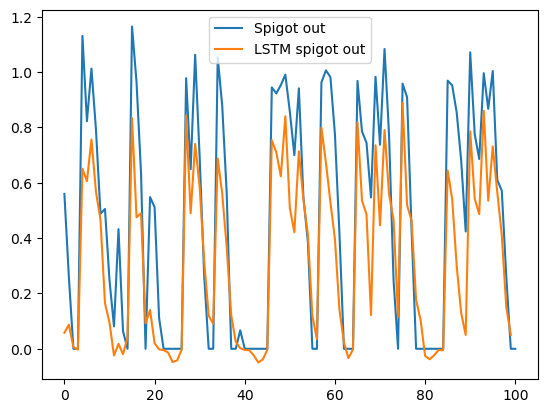

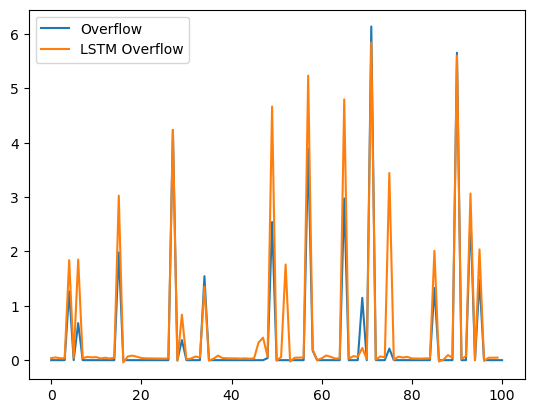

Spigot NSE 0.8064
Overflow NSE 0.8637
Mass into the system:  4266.42419962856
Mass out or left over: 4228.317369643828
percent mass resudual: 1%


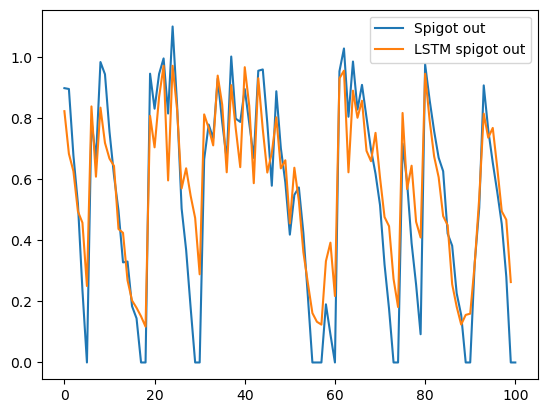

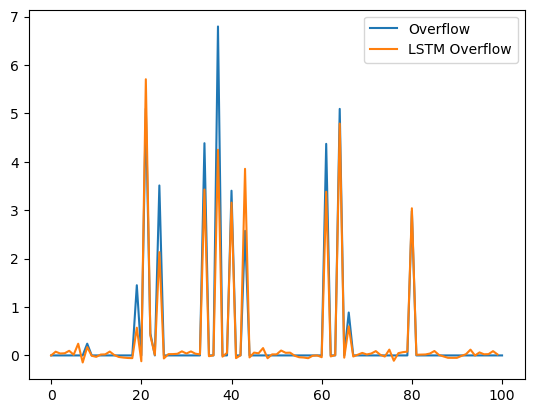

Spigot NSE 0.83
Overflow NSE 0.8902
Mass into the system:  5075.217891219345
Mass out or left over: 5032.053431903699
percent mass resudual: 1%


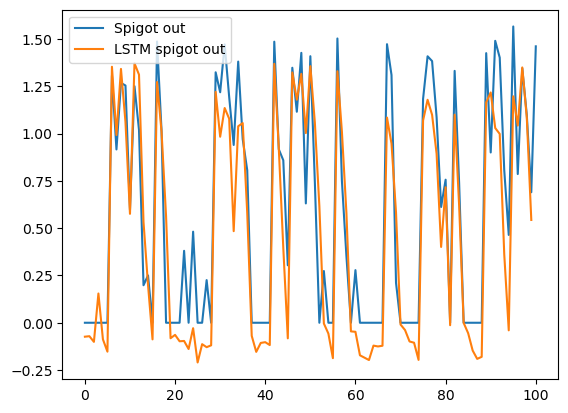

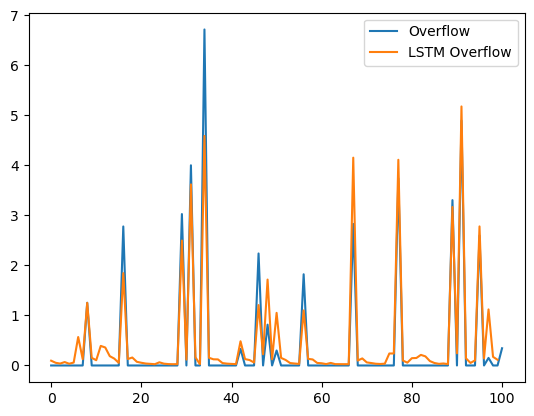

Spigot NSE 0.8222
Overflow NSE 0.8747
Mass into the system:  5177.047995132249
Mass out or left over: 5167.63478832811
percent mass resudual: 0%


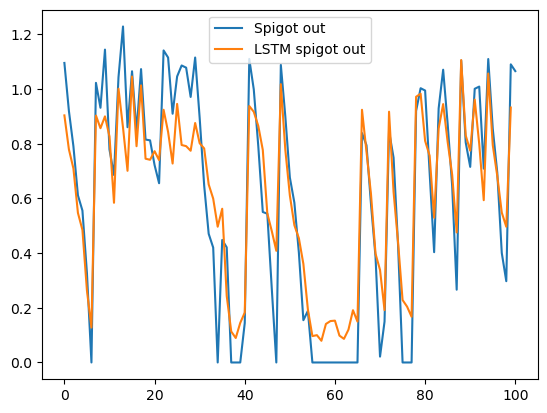

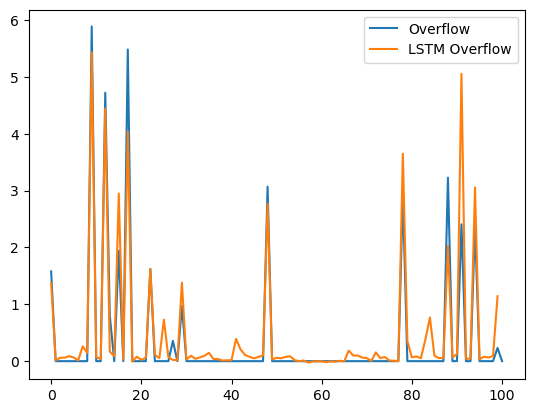

In [32]:
for ibuc in buckets_for_val:
    check_validation_period(lstm, np_val_seq_X, ibuc)

### todo... shorten the next experiments using the 'train_model' function defined above...?

# 3. Experimentation

Now that we have a general model setup and training/validation framework, we can use it to experiment and learn.


### 3.1 Changing 'ground truth' data and repeating the model development

Try to change some bucket configuration attributes here, for example:
- to simulate a more "flashy" system, reduce the probability of heavy precipitation and increase the magnitude.
- to simulate smaller buckets, reduce the size of the bucket attributes
- or to add more noise, increase noise from 0.1 to different values 

In [38]:
rain_probability_range = {"None": [0.6, 0.7], "Light": [0.5, 0.8], "Heavy": [0.05, 0.1]}
rain_depth_range = {"Light": [0, 2], "Heavy": [6, 14]}

bucket_attributes_range = {"A_bucket": [1.0, 2.0],          # [m^2]
                           "A_spigot": [0.1, 0.2],          # [m^2]
                           "H_bucket": [5.0, 6.0],          # [m]
                           "H_spigot": [1.0, 3.0],          # [m]
                           "K_infiltration": [1e-7, 1e-9], # ... units?
                           "ET_parameter": [7, 9]          # ... units?
                          }

noise = {"pet": 0.1, "et": 0.1, "q": 0.1, "head": 0.1} 

Re-generate 'ground truth' data

Bucket: 36
Overflow mean: 1.97
Overflow max: 15.63


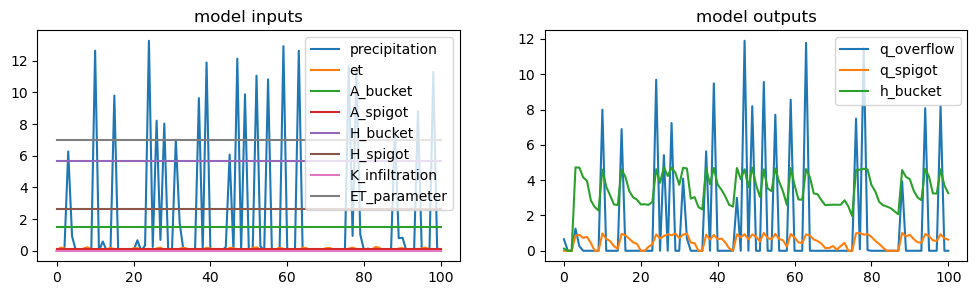

Bucket: 37
Overflow mean: 1.72
Overflow max: 15.77


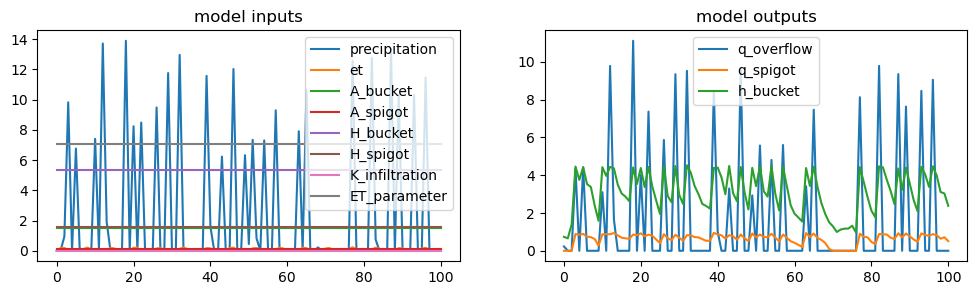

Bucket: 38
Overflow mean: 1.81
Overflow max: 15.91


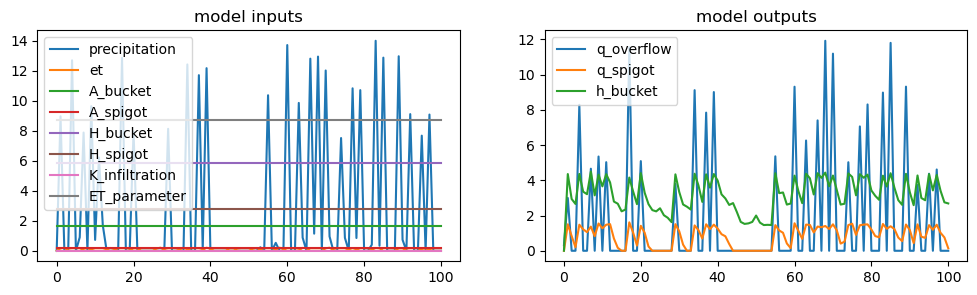

Bucket: 39
Overflow mean: 1.75
Overflow max: 15.04


In [ ]:
buckets, h_water_level, mass_overflow = setup_buckets()
in_list = generate_forcing_timeseries()

bucket_dictionary = {}
for ibuc in range(n_buckets):
    bucket_dictionary[ibuc] = run_bucket_simulation(ibuc)
    
for ibuc in buckets_for_val:
    viz_simulation(ibuc)
    

Re-create new data loaders

In [ ]:
scaler_in, scaler_out = fit_scaler()
train_loader, np_train_seq_X, np_train_seq_y = make_data_loader(train_start, train_end, buckets_for_training)
val_loader, np_val_seq_X, np_val_seq_y = make_data_loader(val_start, val_end, buckets_for_val)
test_loader, np_test_seq_X, np_test_seq_y = make_data_loader(test_start, test_end, buckets_for_test)

Re-intitate the LSTM and train model with the new data

In [ ]:
lstm = LSTM1(num_classes=n_output,  
             input_size=n_input,    
             hidden_size=hidden_state_size, 
             num_layers=num_layers, 
             batch_size=batch_size, 
             seq_length=seq_length).to(device=device)

train_model(lstm, train_loader, buckets_for_training)

viz_learning_curve(results)

for ibuc in buckets_for_val:
    check_validation_period(lstm, np_val_seq_X, ibuc)

### 3.1 Training the model with increasing number of training buckets 
We will increase the number of training buckets, store the results for each bucket, and plot the comparative results for the loss and RMSE metrics.

In [ ]:
criterion = nn.MSELoss()  # Use costome loss function.
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate[0])

# Increase the number of training buckets
buckets_for_training = list(range(1, n_buckets_split["train"]-1))

# Create a dictionary to store the results
results = {}

epoch_bar = tqdm(range(num_epochs),desc="Training", position=0, total=num_epochs)

for epoch in epoch_bar:
    
    for ibuc in buckets_for_training:
        
        batch_bar = tqdm(enumerate(train_loader[ibuc]),
                         desc="Bucket: {}, Epoch: {}".format(str(ibuc),str(epoch)),
                         position=1,
                         total=len(train_loader[ibuc]), leave=False, disable=True)

        for i, (data, targets) in batch_bar:

            optimizer.zero_grad()

            optimizer = optim.Adam(lstm.parameters(), lr=learning_rate[epoch])

            data = data.to(device=device)
            targets = targets.to(device=device)

            # Forward
            lstm_output = lstm(data) 
            loss = criterion(lstm_output,targets)

            #backward
            optimizer.zero_grad()
            loss.backward()

            # gradient descent or adam step
            optimizer.step()

            batch_bar.set_postfix(loss=loss.cpu().item(),
                                  RMSE="{:.2f}".format(loss**(1/2)),
                                  epoch=epoch)
            batch_bar.update()

        with torch.no_grad():
            rmse_list = []
            for i, (data_, targets_) in enumerate(train_loader[ibuc]):
                data_ = data_.to(device=device)
                targets_ = targets_.to(device=device)
                lstm_output_ = lstm(data_)
                MSE_ = criterion(lstm_output_, targets_)
                rmse_list.append(MSE_**(1/2))

        meanrmse = np.mean(np.array(torch.Tensor(rmse_list)))
        epoch_bar.set_postfix(loss=loss.cpu().item(),
                              RMSE="{:.2f}".format(meanrmse),
                              epoch=epoch)
        batch_bar.update()

        # Store the results for each bucket
        if ibuc not in results:
            results[ibuc] = {"loss": [], "RMSE": []}
        results[ibuc]["loss"].append(loss.cpu().item())
        results[ibuc]["RMSE"].append(meanrmse)


In [ ]:
#import matplotlib.pyplot as plt

criterion = nn.MSELoss()  # Use costome loss function.
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate[0])

# Increase the number of training buckets
buckets_for_training = list(range(1, 5))

# Create a dictionary to store the results
results = {}

epoch_bar = tqdm(range(num_epochs),desc="Training", position=0, total=num_epochs)

for epoch in epoch_bar:
    
    for ibuc in buckets_for_training:
        
        batch_bar = tqdm(enumerate(train_loader[ibuc]),
                         desc="Bucket: {}, Epoch: {}".format(str(ibuc),str(epoch)),
                         position=1,
                         total=len(train_loader[ibuc]), leave=False, disable=True)

        for i, (data, targets) in batch_bar:

            optimizer.zero_grad()

            optimizer = optim.Adam(lstm.parameters(), lr=learning_rate[epoch])

            data = data.to(device=device)
            targets = targets.to(device=device)

            # Forward
            lstm_output = lstm(data) 
            loss = criterion(lstm_output,targets)

            #backward
            optimizer.zero_grad()
            loss.backward()

            # gradient descent or adam step
            optimizer.step()

            batch_bar.set_postfix(loss=loss.cpu().item(),
                                  RMSE="{:.2f}".format(loss**(1/2)),
                                  epoch=epoch)
            batch_bar.update()

        with torch.no_grad():
            rmse_list = []
            for i, (data_, targets_) in enumerate(train_loader[ibuc]):
                data_ = data_.to(device=device)
                targets_ = targets_.to(device=device)
                lstm_output_ = lstm(data_)
                MSE_ = criterion(lstm_output_, targets_)
                rmse_list.append(MSE_**(1/2))

        meanrmse = np.mean(np.array(torch.Tensor(rmse_list)))
        epoch_bar.set_postfix(loss=loss.cpu().item(),
                              RMSE="{:.2f}".format(meanrmse),
                              epoch=epoch)
        batch_bar.update()

        # Store the results for each bucket
        if ibuc not in results:
            results[ibuc] = {"loss": [], "RMSE": []}
        results[ibuc]["loss"].append(loss.cpu().item())
        results[ibuc]["RMSE"].append(meanrmse)


In [ ]:
# Plot the comparative results
for ibuc in results:
    plt.plot(results[ibuc]["loss"], label="Bucket {}".format(ibuc))
plt.title("Loss vs Epoch for Different Buckets")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

for ibuc in results:
    plt.plot(results[ibuc]["RMSE"], label="Bucket {}".format(ibuc))
plt.title("RMSE vs Epoch for Different Buckets")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.show()

### 2.8 Experimentation: Evaluating the number of training buckets using Information Theory metrics
Now we use Entropy and Mutual Information as metrics of evaluation.

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import entropy, mutual_info_score
from sklearn.metrics import mutual_info_score

criterion = nn.MSELoss()  # Use costome loss function.
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate[0])

# Increase the number of training buckets
buckets_for_training = [1, 2, 3, 4, 5]

# Create a dictionary to store the results
results = {}

epoch_bar = tqdm(range(num_epochs),desc="Training", position=0, total=num_epochs)

for epoch in epoch_bar:
    
    for ibuc in buckets_for_training:
        
        batch_bar = tqdm(enumerate(train_loader[ibuc]),
                         desc="Bucket: {}, Epoch: {}".format(str(ibuc),str(epoch)),
                         position=1,
                         total=len(train_loader[ibuc]))

        for i, (data, targets) in batch_bar:

            optimizer.zero_grad()

            optimizer = optim.Adam(lstm.parameters(), lr=learning_rate[epoch])

            data = data.to(device=device)
            targets = targets.to(device=device)

            # Forward
            lstm_output = lstm(data) 
            loss = criterion(lstm_output,targets)

            #backward
            optimizer.zero_grad()
            loss.backward()

            # gradient descent or adam step
            optimizer.step()

            # Compute entropy and mutual information
            entropy_val = entropy(lstm_output.cpu().detach().numpy().flatten())
            mi_val = mutual_info_score(targets.cpu().detach().numpy().flatten(), lstm_output.cpu().detach().numpy().flatten())

            batch_bar.set_postfix(loss=loss.cpu().item(),
                                  RMSE="{:.2f}".format(loss**(1/2)),
                                  entropy="{:.2f}".format(entropy_val),
                                  MI="{:.2f}".format(mi_val),
                                  epoch=epoch)
            batch_bar.update()

        with torch.no_grad():
            rmse_list = []
            entropy_list = []
            mi_list = []
            for i, (data_, targets_) in enumerate(train_loader[ibuc]):
                data_ = data_.to(device=device)
                targets_ = targets_.to(device=device)
                lstm_output_ = lstm(data_)
                MSE_ = criterion(lstm_output_, targets_)
                rmse_list.append(MSE_**(1/2))
                entropy_val_ = entropy(lstm_output_.cpu().detach().numpy().flatten())
                mi_val_ = mutual_info_score(targets_.cpu().detach().numpy().flatten(), lstm_output_.cpu().detach().numpy().flatten())
                entropy_list.append(entropy_val_)
                mi_list.append(mi_val_)

        epoch_bar.set_postfix(loss=loss.cpu().item(),
                              RMSE="{:.2f}".format(np.mean(np.array(rmse_list))),
                              entropy="{:.2f}".format(np.mean(np.array(entropy_list))),
                              MI="{:.2f}".format(np.mean(np.array(mi_list))),
                              epoch=epoch)
        batch_bar.update()

        # Store the results for each bucket
        if ibuc not in results:
            results[ibuc] = {"loss": [], "RMSE": [], "entropy": [], "MI": []}
        results[ibuc]["loss"].append(loss.cpu().item())
        results[ibuc]["RMSE"].append(np.mean(np.array(rmse_list)))
        results[ibuc]["entropy"].append(np.mean(np.array(entropy_list)))
        results[ibuc]["MI"].append(np.mean(np.array(mi_list)))

# Plot the comparative results, first plot entropy 
for ibuc in results:
    plt.plot(results[ibuc]["entropy"], label="Bucket {}".format(ibuc))
plt.title("Entropy vs Epoch for Different Buckets")
